# Multimodal LLMs

State-of-the-art LLMs such as `GPT-4o` and Gemini 1.5 are multimodal LLMs, which means they accept images as well as text as input. (Some support audio and video as well.) The ability for LLMs to consume images opens up a world of possibilities for software developers. Let's look at a few examples — first using `GPT-4o`, and then using Gemini 1.5 Flash.

## GPT-4o

OpenAI's flagship `GPT-4o` model accepts text and images as input. Let's take it for a spin and test out its multimodal capabilities. Start by loading a photo of a cute Corgi:

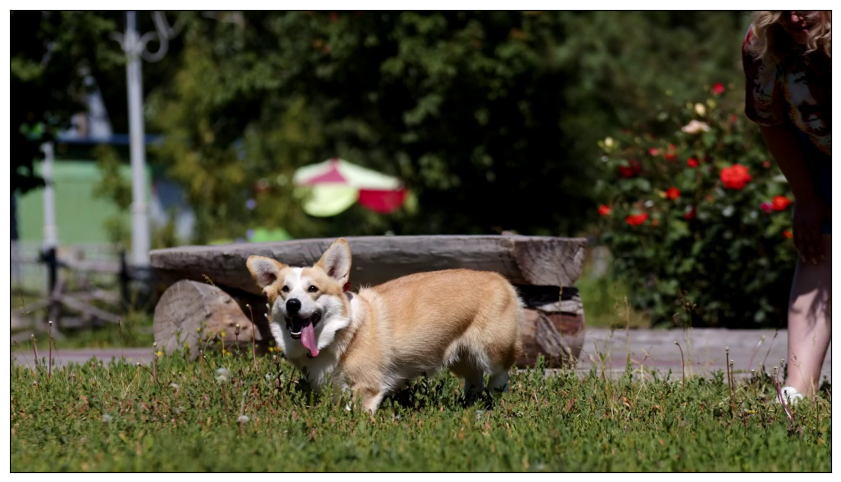

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('Data/corgi.png')
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(image)

`GPT-4o` currently requires images to be passed using data URLs, so define a function that generates a data URL from an image:

In [2]:
import base64
from io import BytesIO

def get_data_url(image):
    io = BytesIO()
    image.save(io, format='PNG')
    bytes = base64.b64encode(io.getvalue()).decode('utf-8')
    return f'data:image/png;base64,{bytes}'

Now use `GPT-4o` to analyze the image:

In [3]:
from openai import OpenAI

client = OpenAI(api_key='OPENAI_API_KEY')

messages = [
    {
        'role': 'user',
        'content': [
            { 'type': 'text', 'text': 'Describe what you see in this image' },
            { 'type': 'image_url', 'image_url': { 'url': get_data_url(image) }}
        ]
    }
]

response = client.chat.completions.create(
    model='gpt-4o',
    messages=messages,
    stream=True
)

for chunk in response:
    content = chunk.choices[0].delta.content
    if content is not None:
        print(content, end='')

The image depicts an outdoor scene with a corgi dog standing on grass. The corgi has its tongue out and appears to be panting, which could suggest it is a warm day. In the background, there is a rustic wooden bench, some greenery, and blurred flowers. Additionally, part of a person is visible to the right, wearing a patterned top and denim shorts. It seems like a bright, sunny day in a park or garden setting.

Next, use `GPT-4o` to summarize the contents of a video. Begin by defining a function that takes a path to a video file as input and returns a list of frames from the video. This sample requires the Python package [opencv-python](https://pypi.org/project/opencv-python/). If it's not installed, now's a good time to install it.

In [4]:
import cv2

def process_video(path, seconds_per_frame=1):
    frames = []

    video = cv2.VideoCapture(path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)

    # Loop through the video and extract frames at the specified sampling rate
    for i in range(total_frames):
        video.set(cv2.CAP_PROP_POS_FRAMES, i * frames_to_skip)
        success, frame = video.read()

        if not success:
            break

        _, buffer = cv2.imencode('.jpg', frame)
        bytes = base64.b64encode(buffer).decode('utf-8')
        data_url = f'data:image/jpeg;base64,{bytes}'
        frames.append(data_url)

    video.release()
    print(f'Extracted {len(frames)} frames')
    return frames

Use the `process_video` function to extract frames from a video. The video was downloaded from [Mixkit](https://mixkit.co/), an online content service that makes a variety of videos available for free.

In [5]:
frames = process_video('Data/corgi.mp4')

Extracted 6 frames


Pass the frames to `GPT-4o` and ask it to summarize them:

In [6]:
from openai import OpenAI

response = client.chat.completions.create(
    model='gpt-4o',
    messages = [{
        'role': 'user',
        'content': [
            { 'type': 'text', 'text': 'Generate a brief video summary from the following frames extracted from the video' },
            *map(lambda url: { 'type': 'image_url', 'image_url': { 'url': url }}, frames)
        ],
    }],
    stream=True
)

for chunk in response:
    content = chunk.choices[0].delta.content
    if content is not None:
        print(content, end='')

In this video, a playful and energetic corgi enjoys a beautiful day outdoors. The sequence begins with the corgi standing in a park next to a log bench, with its tongue hanging out, appearing happy and content. As the video progresses, the corgi starts running towards the camera through the green grass, eagerly chasing after a bright green, bouncy ball. Each frame captures the corgi's enthusiasm, with its ears perked up and tongue flopping as it bounds forward. The background features a mix of greenery, flowers, and park structures, providing a charming and serene setting for the dog's playful antics. The video encapsulates a joyful moment of outdoor fun and excitement.

Load a map of Zork's Underground Empire:

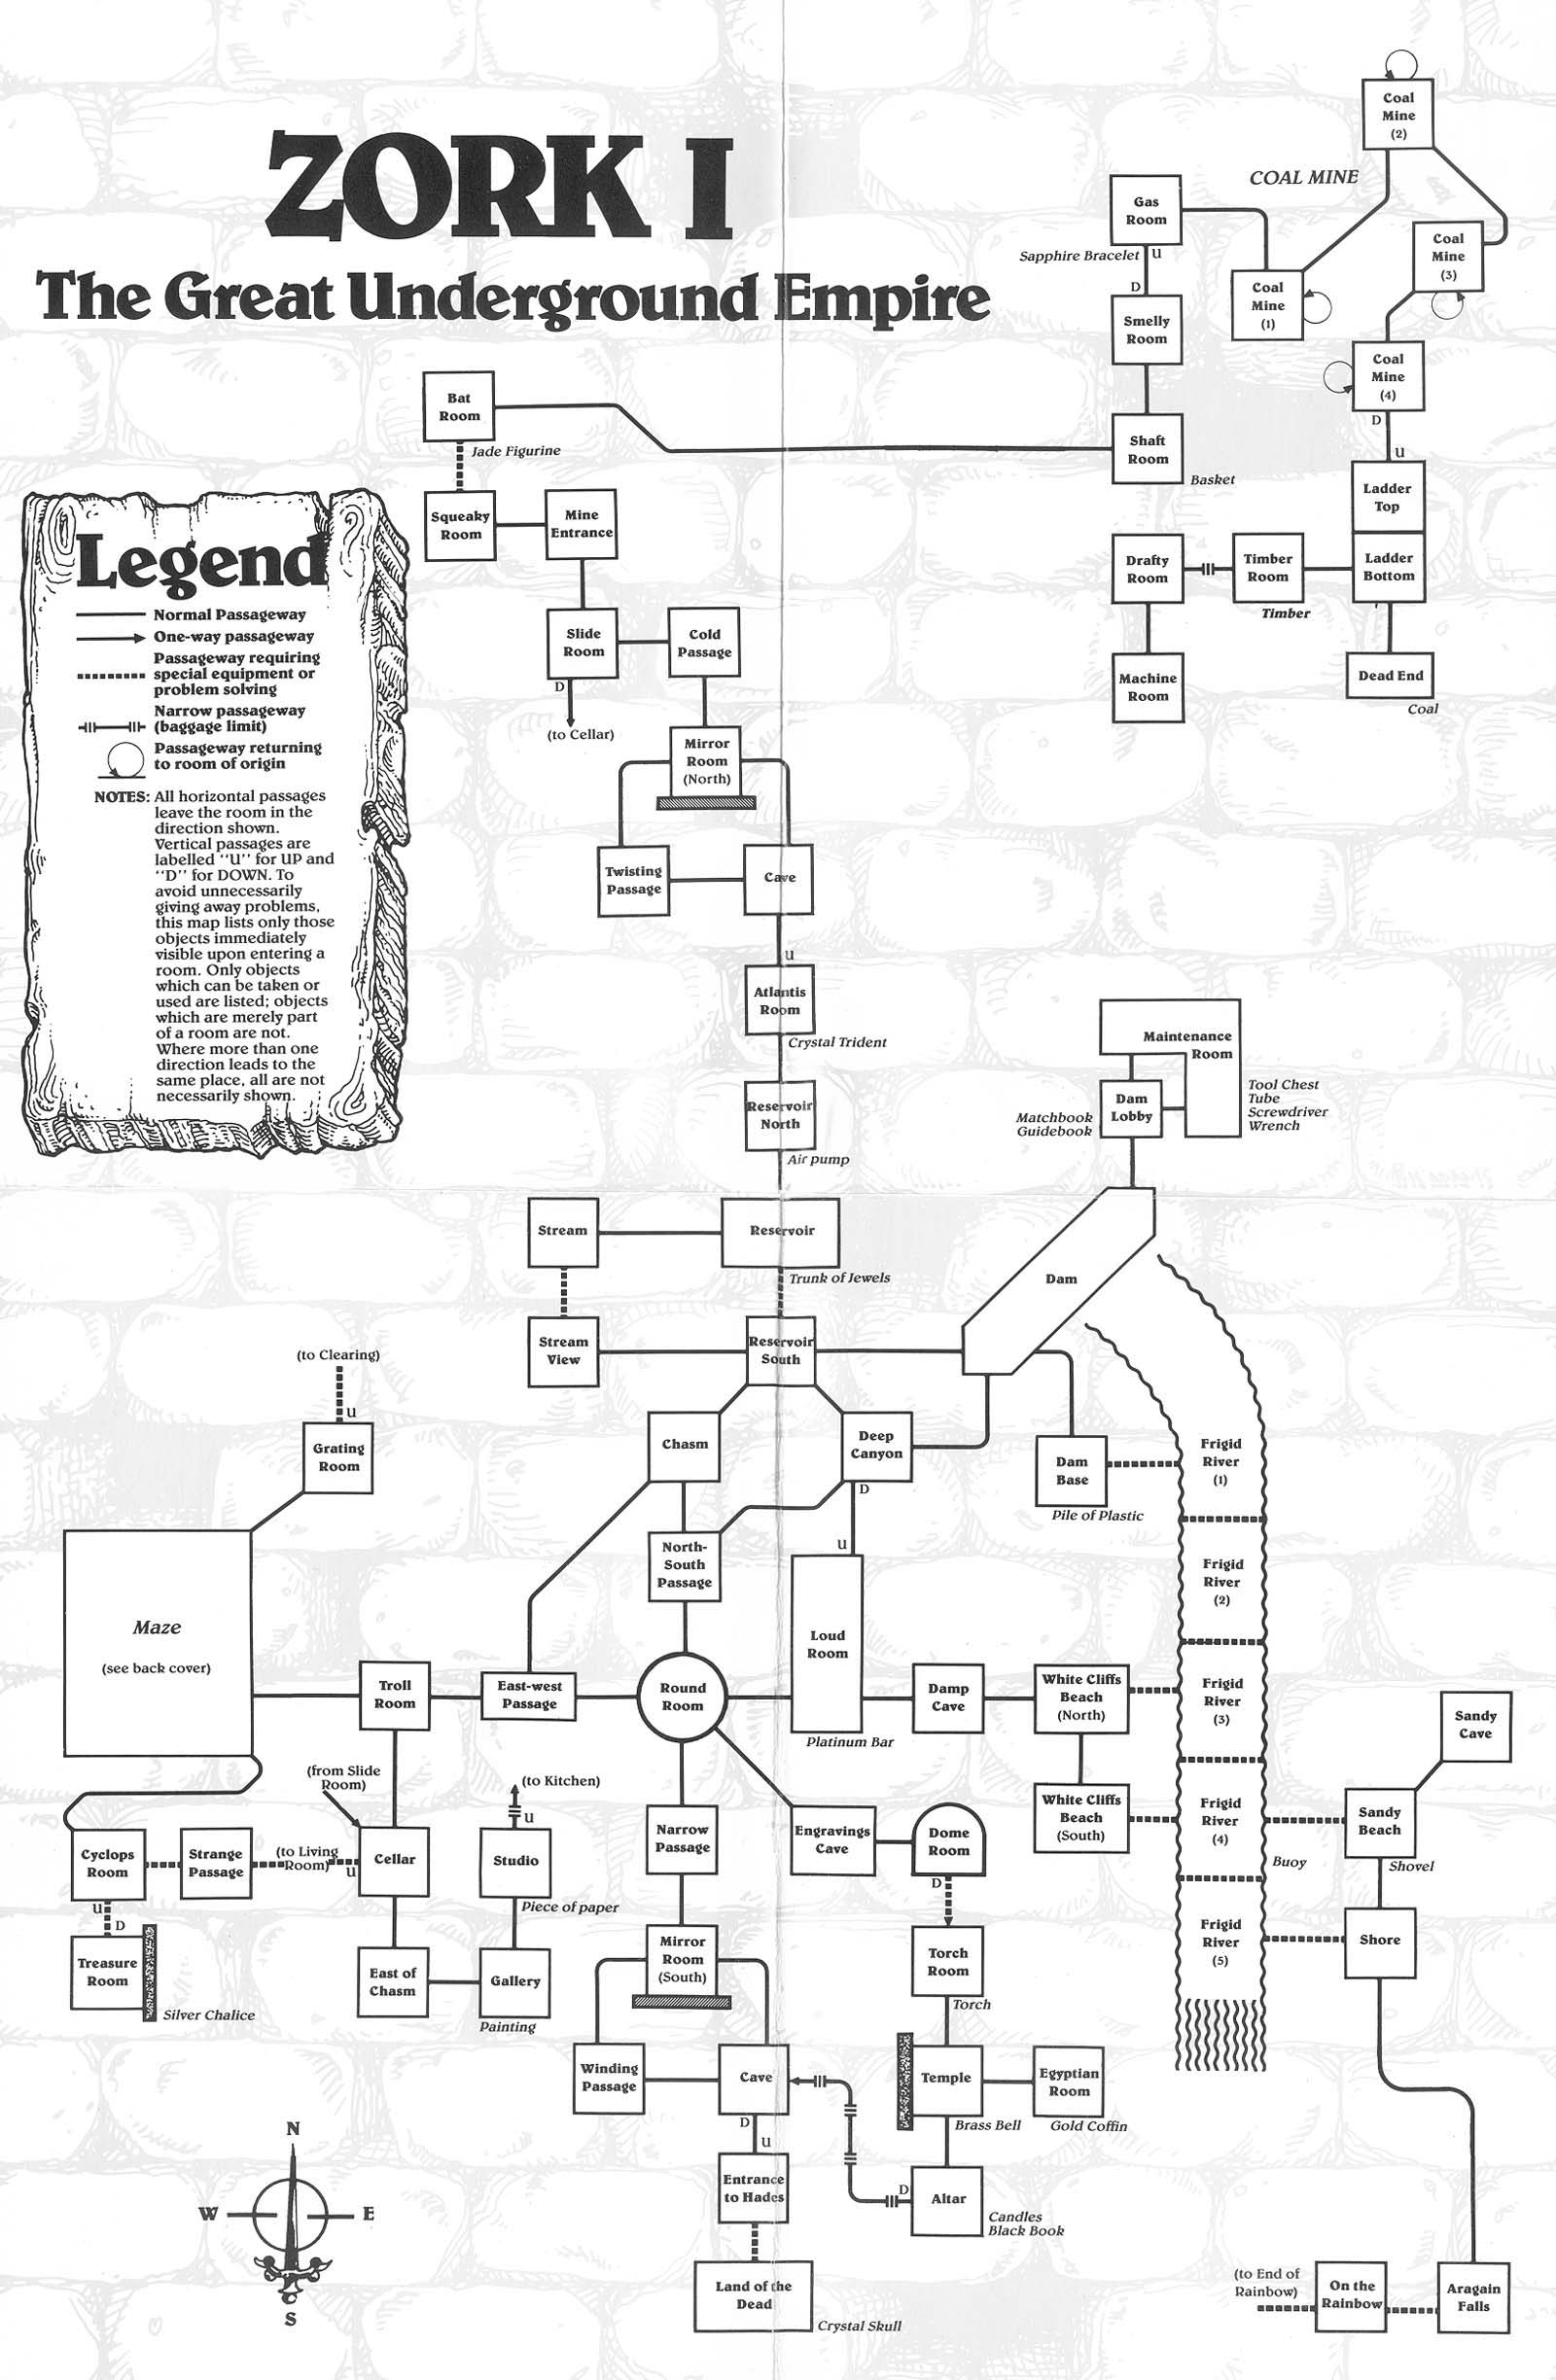

In [20]:
image = Image.open('Data/zork.jpg')
display(image)

Now parse the map and build a JSON representation of its contents:

In [21]:
prompt = '''
    This image comes from a legendary text-based adventure game named Zork. It contains
    a map of the locations that make up Zork's Underground Empire. Users move from location
    to location by entering commands such as "go north" and "go west." Generate a JSON array
    from all the locations depicted in the map and represent individual locations using the
    following format:

    {
        "name": "Kitchen",
        "exits": { "west": "Living Room", "up": "Attic", "down": "Cellar" },
        "items": ["Lantern", "Brown Sack", "Glass Bottle"]
    }
    '''

messages = [
    {
        'role': 'user',
        'content': [
            { 'type': 'text', 'text': prompt },
            { 'type': 'image_url', 'image_url': { 'url': get_data_url(image) }}
        ]
    }
]

response = client.chat.completions.create(
    model='gpt-4o',
    messages=messages,
    response_format={ 'type': 'json_object' },
    stream=True
)

for chunk in response:
    content = chunk.choices[0].delta.content
    if content is not None:
        print(content, end='')

{
    "locations": [
        {
            "name": "Bat Room",
            "exits": { "down": "Squeaky Room" },
            "items": []
        },
        {
            "name": "Squeaky Room",
            "exits": { "up": "Bat Room", "down": "Mine Entrance" },
            "items": []
        },
        {
            "name": "Mine Entrance",
            "exits": { "up": "Squeaky Room", "down": "Slide Room" },
            "items": []
        },
        {
            "name": "Slide Room",
            "exits": { "up": "Cold Passage", "down": "Mirror Room (North)" },
            "items": []
        },
        {
            "name": "Cold Passage",
            "exits": { "up": "Mirror Room (North)", "down": "Drafty Room" },
            "items": []
        },
        {
            "name": "Smelly Room",
            "exits": { "west": "Gas Room", "north": "Shaft Room" },
            "items": []
        },
        {
            "name": "Gas Room",
            "exits": { "east": "Smelly Room", "w

## Gemini 1.5 Flash

Google's Gemini 1.5 Flash is also an excellent multimodal LLM. It accepts text, images, video, and audio as input. Let's use it to analyze the same Corgi image that `GPT-4o` analyzed above. Start by loading the image:

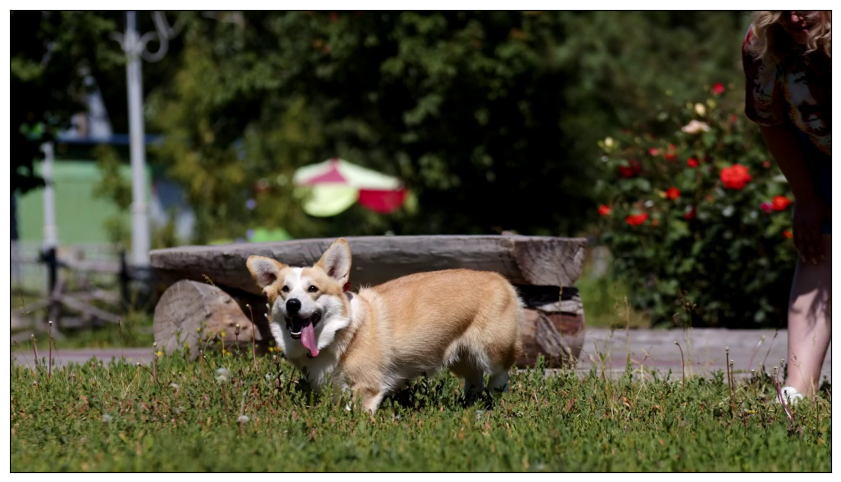

In [9]:
image = Image.open('Data/corgi.png')
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(image)

Ask Gemini to describe it:

In [10]:
import google.generativeai as genai

genai.configure(api_key='GOOGLE_API_KEY')
model = genai.GenerativeModel('gemini-1.5-flash')

response = model.generate_content([image, 'Describe this image'], stream=True)

for chunk in response:
    print(chunk.text, end='')

A corgi with a white chest and white paws stands in front of a wooden bench.  The corgi has its tongue out and is looking to the left of the frame.  The bench is made of several logs stacked on top of each other. The corgi is in a grassy area with a woman walking away in the background. The woman is wearing a colorful shirt and has long blonde hair. There is a bush of roses in the background, too.  A white sign that says "No Parking" can be seen in the background. The scene is a sunny outdoor setting.

Gemini Flash was trained to do object detection, too. Use it to generate bounding boxes for each dog in the photo:

In [11]:
prompt = '''
    Return a bounding box for each dog in this image using the following JSON format:
    {
        "xmin": xmin,
        "ymin": ymin,
        "xmax": xmax,
        "ymax": ymax
    }
    return an array of objects, even if the the array contains just one element. Do not return markdown. Return JSON only.
    '''

response = model.generate_content([image, prompt])
print(response.text)

[
  {
    "xmin": 286,
    "ymin": 494,
    "xmax": 624,
    "ymax": 884
  }
]


Draw the bounding box onto the image:

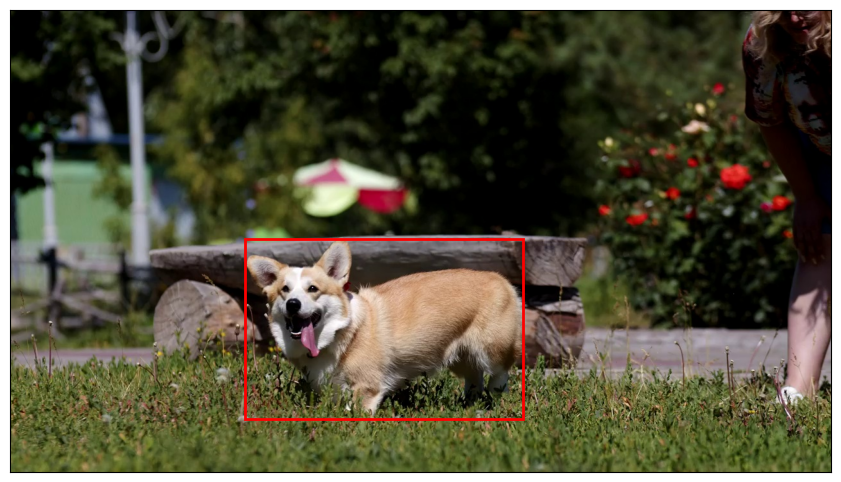

In [12]:
import json
import matplotlib.patches as patches

boxes = json.loads(response.text)
image_width, image_height = image.size

fig, ax = plt.subplots(1, figsize=(12, 6))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(image)

for box in boxes:
    xmin = (box['xmin'] / 1000) * image_width
    ymin = (box['ymin'] / 1000) * image_height
    xmax = (box['xmax'] / 1000) * image_width
    ymax = (box['ymax'] / 1000) * image_height
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

Gemini Flash can analyze video, too. You don't even have to extract frames from the video:

In [13]:
import time

# Upload the video
print('Uploading video')
video = genai.upload_file(path='Data/corgi.mp4')

# Wait until video processing is complete
while video.state.name == 'PROCESSING':
    time.sleep(1)
    video = genai.get_file(video.name)

if video.state.name == 'FAILED':
    print('Video processing failed')
else:
    print('Processing complete')

Uploading video
Processing complete


Summarize the video.

In [14]:
response = model.generate_content([video, 'Generate a brief summary of this video'], stream=True)

for chunk in response:
    print(chunk.text, end='')

A corgi dog runs towards the camera with its tongue out. It is on green grass in a park, with a wooden bench and a white fence in the background.  The dog appears to be happy and playful. 


Load a photo depicting a confusing array of parking signs:

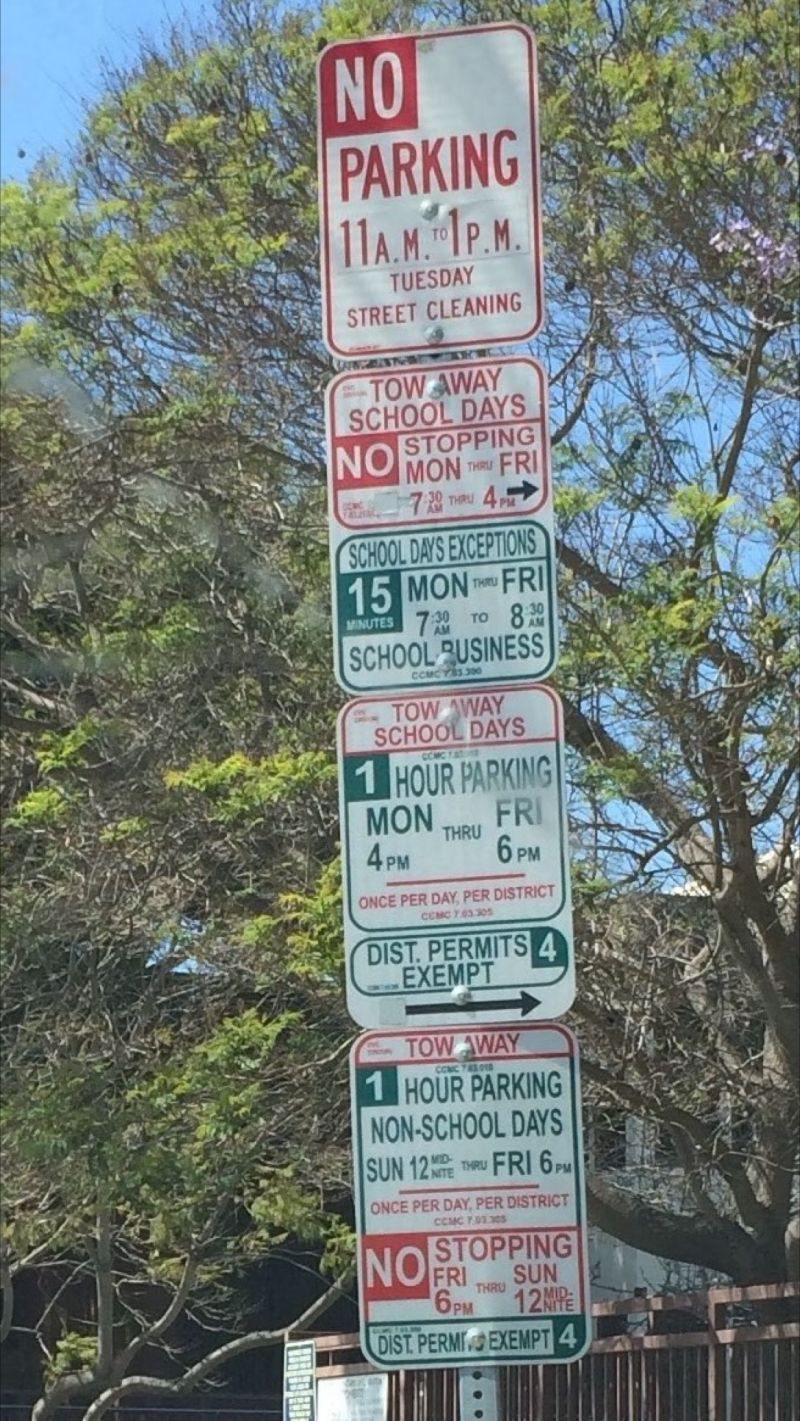

In [15]:
image = Image.open('Data/signs.png')
display(image)

Can Gemini Flash make sense of all those signs and help you decide whether it's OK to park?

In [16]:
prompt = """
    It's 5:00 p.m. on Thursday. Am I allowed to park here for 30 minutes to drop off a package?
    Think it through step by step, and explain your reasoning. Assume that it's OK to park unless
    the rules explicitly state otherwise. Consider all the signs in making a determination, and
    do not return markup in your response.
    """
response = model.generate_content([image, prompt], stream=True)

for chunk in response:
    print(chunk.text, end='')

You can park for 30 minutes. The signs say no parking on Tuesdays from 11 am to 1 pm. 
The signs are clear about parking restrictions. 
However, the signs don't say that it's not ok to park on Thursday between 5:00 pm and 5:30 pm. 
Therefore, parking for 30 minutes on Thursday between 5:00 pm and 5:30 pm is acceptable.